In [22]:
import cv2
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [36]:
def GetData(index):
    fp = 'orl_faces/'
    X,y = pd.DataFrame(np.array([])),[]
    for i in range(1,41):
        for j in index:
            imgPath = fp+'s'+str(i)+'/'+str(j)+'.pgm'
            t_img = cv2.imread(imgPath,0)
            t_img = t_img.reshape(1,t_img.size)
            X = pd.concat([X,pd.DataFrame(t_img)],axis = 0)
            y.append(i)
    # y = np.array(y).ravel()#可有可无
    return X,y

In [3]:
def StdData(X_train,X_test):
    stdScaler = StandardScaler().fit(X_train)
    X_train = stdScaler.transform(X_train)
    X_test = stdScaler.transform(X_test)
    return X_train,X_test

In [10]:
def PcaDimRedu(X_train,X_test,comNum = 20):
    pca = PCA(n_components = comNum).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    return X_train,X_test

In [4]:
def GetCorrRate(y_test,y_test_pred):
    corrNum = 0
    for i in range(len(y_test)):
        if y_test[i] == y_test_pred[i]:
            corrNum = corrNum + 1
    return corrNum / len(y_test)

In [5]:
def plotComponent_correctRate_runningTime(comNum,corrRates,runningTime):
    x = np.array(comNum)
    y1 = np.array(corrRates)
    y2 = np.array(runningTime)
    x_new = np.linspace(x.min(),x.max(),500)
    y1 = make_interp_spline(x,y1)(x_new)
    y2 = make_interp_spline(x,y2)(x_new)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(x_new,y1,'r',label = 'correct rate')
    ax1.legend(loc = 1)
    ax1.set_ylabel("Correct Rate")
    
    ax2 = ax1.twinx()
    ax2.plot(x_new,y2,'g',label = 'Running Time')
    ax2.legend(loc = 2)
    ax2.set_ylabel('Running Time(s)')
    
    ax1.set_xlabel("The number of component")
    return None
    
    

In [6]:
def plotComponent_correctRate(comNum,allCorrRates,kernelNames):
    plt.xlabel('The number of component')
    plt.ylabel('Correct Rate')
    x = np.array(comNum)
    x_new = np.linspace(x.min(),x.max(),500)
    for i in range(len(kernelNames)):
        y = np.array(allCorrRates[i])
        y_smooth = make_interp_spline(x,y)(x_new)
        plt.plot(x_new,y_smooth,label = kernelNames[i])
    plt.legend(kernelNames)
    return None

In [20]:
def componentImpact(X_train,y_train,X_test,y_test):
    comNum = [10,15,20,50,100,150,200]
    corrRates,runningTime = [],[]
    
    for i in comNum:
        startTime = time.time()
        X_train_std,X_test_std = PcaDimRedu(X_train,X_test,i)
        svm = SVC(kernel = 'poly').fit(X_train_std,y_train)
        y_test_pred = svm.predict(X_test_std)
        
        corrRate = GetCorrRate(y_test,y_test_pred)
        endTime = time.time()
        corrRates.append(corrRate)
        runningTime.append(endTime-startTime)
    plotComponent_correctRate_runningTime(comNum,corrRates,runningTime)
    return None    

In [14]:
X_train_std,X_test_std = PcaDimRedu(X_train,X_test,20)

In [18]:
svm = SVC(kernel = 'poly').fit(X_train_std,y_train)

In [19]:
 y_test_pred = svm.predict(X_test_std)

In [16]:
X_train_std.shape

(200, 20)

In [8]:
def kernelSelect(X_train,y_train,X_test,y_test):
    kernelNames = ['poly','linear','rbf','sigmoid']
    comNum = [10,15,20,50,100,150,200]
    allCorrRate = []#存不同kernel情况下，不同降维特征的准确率
    
    for i in range(len(kernelNames)):
        corrRates = []
        for j in comNum:
            X_train_std,X_test_std = PcaDimRedu(X_train,X_test,j)
            svm = SVC(kernel = kernelNames[i]).fit(X_train_std,y_train)
            y_test_pred = svm.predict(X_test_std)
            corrRate = GetCorrRate(y_test,y_test_pred)
            corrRates.append(corrRate)
        allCorrRate.append(corrRates)
    plotComponent_correctRate(comNum,allCorrRate,kernelNames)
    return None

In [134]:
def Cross_validation():
    X,y = GetData(range(1,11))
    ss = StandardScaler()
    # X_train = ss.fit_transform(X_train)
    X_std = ss.fit_transform(X)
    pca=PCA(n_components=20)#设置降到多少维
    pca.fit(X_std)

    new_train_data=pca.transform(X_std)
    # new_test_data=pca.fit_transform(test_data)
    y = np.array(y)
    clf = SVC(random_state=0)#kernel='rbf'默认
    result = cross_val_score(clf, new_train_data, y, cv=5, scoring='recall_macro')
    print(result)
    

In [135]:
Cross_validation()
# 5折交叉验证下的准确率

[0.975  0.95   0.9875 0.975  0.9375]


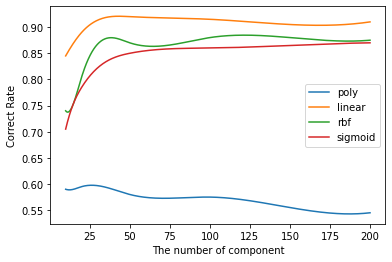

In [43]:
X_train,y_train = GetData(range(1,6))
X_test,y_test = GetData(range(6,11))

X_train,X_test = StdData(X_train,X_test)
#画不同kernel，不同pca维度的准确率图像
kernelSelect(X_train,y_train,X_test,y_test)

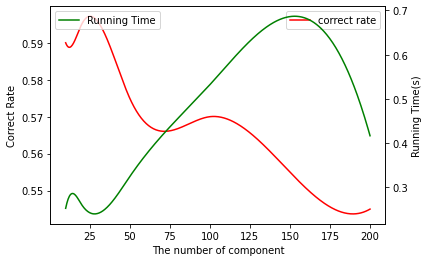

In [44]:
# kernel = 'poly' 情况下不同pca维度的图像
componentImpact(X_train,y_train,X_test,y_test)

In [23]:
X

NameError: name 'X' is not defined

In [24]:
y

NameError: name 'y' is not defined

In [113]:
X,y = GetData(range(1,11))

In [84]:
X

,0,1,2,3,4,5,6,7,8,9,...,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303
0,48.0,49.0,45.0,47.0,49.0,57.0,39.0,42.0,53.0,49.0,...,39.0,44.0,40.0,41.0,49.0,42.0,44.0,47.0,46.0,46.0
0,60.0,60.0,62.0,53.0,48.0,51.0,61.0,60.0,71.0,68.0,...,27.0,35.0,28.0,33.0,31.0,31.0,37.0,32.0,34.0,34.0
0,39.0,44.0,53.0,37.0,61.0,48.0,61.0,45.0,35.0,40.0,...,23.0,30.0,36.0,32.0,28.0,32.0,31.0,29.0,26.0,29.0
0,63.0,53.0,35.0,36.0,33.0,34.0,31.0,35.0,39.0,43.0,...,173.0,169.0,166.0,161.0,158.0,169.0,137.0,41.0,10.0,24.0
0,64.0,76.0,80.0,53.0,34.0,72.0,60.0,66.0,66.0,50.0,...,31.0,28.0,34.0,32.0,35.0,34.0,35.0,35.0,37.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,123.0,121.0,126.0,122.0,127.0,127.0,123.0,124.0,123.0,127.0,...,29.0,47.0,34.0,36.0,42.0,34.0,39.0,40.0,35.0,42.0
0,129.0,127.0,133.0,124.0,131.0,129.0,130.0,129.0,127.0,132.0,...,91.0,92.0,93.0,90.0,90.0,92.0,89.0,93.0,93.0,93.0
0,125.0,119.0,124.0,125.0,124.0,121.0,123.0,125.0,123.0,123.0,...,40.0,34.0,38.0,37.0,32.0,41.0,40.0,36.0,39.0,40.0
0,119.0,120.0,120.0,118.0,120.0,121.0,121.0,116.0,120.0,121.0,...,63.0,88.0,87.0,97.0,101.0,91.0,93.0,89.0,94.0,85.0


In [85]:
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,


In [114]:
ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
X_std = ss.fit_transform(X)

In [115]:
X_std

array([[-1.05125993, -1.02502268, -1.15078496, ..., -0.63687931,
        -0.67224364, -0.66490378],
       [-0.71590752, -0.71676625, -0.67275578, ..., -0.95670487,
        -0.94235661, -0.93789482],
       [-1.30277423, -1.16513923, -0.92583005, ..., -1.02066998,
        -1.12243192, -1.05164108],
       ...,
       [ 1.10058468,  0.93660913,  1.07064477, ..., -0.87141805,
        -0.82980954, -0.8013993 ],
       [ 0.93290848,  0.96463244,  0.95816732, ...,  0.25863227,
         0.40820822,  0.22231707],
       [ 1.10058468,  1.07672569,  1.07064477, ..., -0.87141805,
        -0.9198472 , -0.93789482]])

In [116]:
pca=PCA(n_components=20)#设置降到多少维
pca.fit(X)

new_train_data=pca.transform(X)
# new_test_data=pca.fit_transform(test_data)

In [136]:
new_train_data

array([[-44.98686497,   0.79780748,  57.65660109, ..., -16.21149117,
         -1.21559258,   6.58445167],
       [-73.12715966,  30.48094331,  -2.7942089 , ...,  -6.84819268,
         -2.73291628,  19.89296261],
       [-55.55827916,  32.51079789,  36.09077798, ...,  -6.42957408,
          8.64824995,  11.09140112],
       ...,
       [-31.40229174,  -4.984277  , -39.65869395, ..., -11.20441053,
         -0.31612789, -14.25088414],
       [-51.81593777,  -2.73537389, -21.98322655, ...,  -7.0996897 ,
         -8.92654812,   7.22901968],
       [-20.27568188,  -0.10651979, -51.22132165, ...,  -1.41691806,
         -1.04359892,  -2.26642646]])

In [117]:
pca=PCA(n_components=20)#设置降到多少维
pca.fit(X_std)

new_train_data=pca.transform(X_std)
# new_test_data=pca.fit_transform(test_data)

In [118]:
new_train_data.shape

(400, 20)

In [120]:
y = np.array(y)

In [121]:
y.shape

(400,)

In [122]:
clf = svm.SVC(random_state=0)

In [123]:
cross_val_score(clf, new_train_data, y, cv=5, scoring='recall_macro')

array([0.975 , 0.95  , 0.9875, 0.975 , 0.9375])

In [124]:
svm = SVC(kernel = 'poly')
# svm.fit(new_train_data,y)

In [71]:
y_pred = svm.predict(new_train_data)

In [79]:
y_pred = y_pred.tolist()

In [77]:
y.shape

AttributeError: 'list' object has no attribute 'shape'

In [95]:
new_train_data

array([[ 1531.17604911, -1072.18126719, -1867.02575343, ...,
         -730.50385351,   152.06189671,   261.68117801],
       [ 2975.89645415,  -759.88308519,   461.81166499, ...,
         -317.07299039,  -674.67089743,   560.02036895],
       [ 2696.44921967,  -380.51575337, -1004.96184061, ...,
         -431.75719057,   113.46408328,   362.73214691],
       ...,
       [  843.14794032,  -949.73439323,  1541.1420242 , ...,
         -540.45279665,   323.25637648,  -347.21366794],
       [ 1400.61765833, -1276.41046966,   806.91098919, ...,
         -158.26889449,  -184.88193106,   192.53781875],
       [  534.83465374,  -476.89207046,  2058.98859067, ...,
         -496.02340159,  -120.98778633,   -24.34360756]])

In [98]:
y = np.array(y)
y = y.T

In [110]:
y.shape

(150,)

In [126]:
num_folds = 5
kfold = KFold(n_splits=num_folds)
# y_pred = svm.predict(new_train_data)
result= cross_val_score(svm, new_train_data, y, cv=kfold,scoring='recall_macro') 
print (result.mean())

0.0


D:\Download\Anaconda\neirong\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Download\Anaconda\neirong\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Download\Anaconda\neirong\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Download\Anaconda\neirong\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWar

In [100]:
print(result)

[0. 0. 0. 0. 0.]


In [25]:

X_train_std,X_test_std = PcaDimRedu(X,X_test,i)
svm = SVC(kernel = 'poly').fit(X_train_std,y_train)

In [27]:
#交叉验证



NameError: name 'model' is not defined

In [129]:
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score


In [102]:
X, y = datasets.load_iris(return_X_y=True)
clf = svm.SVC(random_state=0)


In [108]:
y.shape

(150,)

In [112]:
cross_val_score(clf, X, y, cv=5, scoring='recall_macro')
# array([0.96..., 0.96..., 0.96..., 0.93..., 1.        ])

array([0.96666667, 0.96666667, 0.96666667, 0.93333333, 1.        ])

In [18]:
fp = 'orl_faces/'
X,y = pd.DataFrame(np.array([])),[]

In [24]:
imgPath = fp+'s'+str(1)+'/'+str(1)+'.pgm'
t_img = cv2.imread(imgPath,0)

# t_img = t_img.reshape(1,t_img.size)

In [26]:
t_img.shape

(112, 92)

In [25]:
t_img.size

10304

In [27]:
type(t_img)

numpy.ndarray

In [19]:
for i in range(1,41):
    for j in range(1,6):
        imgPath = fp+'s'+str(i)+'/'+str(j)+'.pgm'
        t_img = cv2.imread(imagPath,0)
        t_img = t_img.reshape(1,t_img.size)
        X = pd.concat([X,pd.DataFrame(t_img)],axis = 0)
        y.append(i)
# y = np.array(y).ravel()#可有可无
        

In [20]:
data_addrs

[]

In [3]:
X

,0


In [ ]:
def GetData(index):
    fp = 'orl_faces'
    X,y = pd.DataFrame(np.array)